# Análisis de sistemas electorales para la Cámara de Diputadas y Diputados de Chile

En el presente informe, se utilizan los datos de las elecciones parlamentarias
de Chile de 2021 para simular la distribución de escaños en la Cámara de
Diputadas y Diputados bajo distintos sistemas electorales. Para cada sistema,
se presentan ventajas y desventajas, justificadas mediante un análisis numérico
de los resultados (e.g. cálculo del [índice de
Gallagher](https://en.wikipedia.org/wiki/Gallagher_index) y el [índice de
Loosemore-Hanby](https://en.wikipedia.org/wiki/Loosemore%E2%80%93Hanby_index)
para ver disproporcionalidad, y de la [cantidad efectiva de
partidos](https://en.wikipedia.org/wiki/Effective_number_of_parties) para ver
fragmentación).

Se proponen los siguientes sistemas (en cursiva los que aún no se han
analizado):

- Proporcional por distrito
    - D'Hondt estándar (actualmente usado)
    - D'Hondt con umbral nacional (actualmente en discusión)
    - D'Hondt sin pactos
- Proporcional nacional
    - D'Hondt nacional con umbral bajo
    - D'Hondt nacional con umbral alto
- Bipartidistas
    - Binomial
    - Uninominal (first-past-the-post)
- Sistema biproporcional
- Mixtos
    - Mixed-Member Proportional / Additional-Member System
    - *D'Hondt con escaños niveladores*

In [8]:
import numpy as np
import pandas as pd

from data_load_utils import *
from systems import *
from apportionment import Apportionment

## Carga de datos

Primero, se carga a un dataframe el archivo `datos.csv` con una representación
ordenada de todas las votaciones obtenidas durante la elección parlamentaria,
exceptuando candidatos independientes fuera de pacto. La creación de este
archivo fue a partir de los resultados oficiales de las elecciones entregados
por el [Tricel](https://tricel.cl/resultados-de-elecciones/). En el anexo
[`carga_datos.ipynb`](carga_datos.ipynb) se puede ver este proceso con mayor
profundidad.

In [9]:
df = pd.read_csv("datos.csv", index_col=0)

Para las simulaciones en las cuales no se utilizan pactos, creamos una copia
del dataframe donde el pacto de cada candidato es reemplazado por su partido.

In [10]:
df_no_pact = df.copy()
df_no_pact["pact"] = df_no_pact["party"]

En las simulaciones usando D'Hondt, se mantendrá la distribución de escaños del
congreso actual para cada uno de los 28 distritos.

In [11]:
district_seats = pd.Series(
    np.array(
        [3, 3, 5, 5, 7, 8, 8, 8, 7, 8, 6, 7, 5, 6,
        5, 4, 7, 4, 5, 8, 5, 4, 7, 5, 4, 5, 3, 3]
    ),
    index=range(1, 29)
)

Para las simulaciones que utilizan distritos binomiales y uninominales, se
deben redistribuir los distritos existentes. A cada distrito se le asignó una
cantidad de subdistritos en los cuales dividirse, según su cantidad total de
votantes. La asignación se realizó usando el [método de
Huntington-Hill](https://en.wikipedia.org/wiki/Huntington%E2%80%93Hill_method),
el mismo usado para la asignación de escaños a los distintos estados de los
Estados Unidos en su Cámara de Representantes. Usando este método, se
obtuvieron 40 distritos binomiales y 80 distritos uninominales.

Una vez obtenida la cantidad de subdistritos, los candidatos de cada distrito
se reasignaron intentando que cada pacto tuviese una cantidad "equitativa" de
candidatos en cada subdistrito (es decir, si un pacto tenía 9 candidatos en un
distrito que se dividió en 3, se esperarían 3 candidatos del pacto en cada
subdistrito). Esta reasignación no es ideal, pero es útil para un experimento
más exploratorio que riguroso.

In [12]:
# votos totales por distrito
district_votes = df.groupby("district")["votes"].sum()

# escaños iniciales (1 para cada distrito)
initial_seats = pd.Series([1]*28, index=range(1, 29))

huntington_hill_denominator = lambda x: np.sqrt(x * (x + 1))

# asignación de distritos binomiales
bin_split = assign_seats_to_parties(
    district_votes,
    40,
    initial_seats,
    huntington_hill_denominator
)
df_bin = redistrict_candidates(df, bin_split)
districts_bin = df_bin["district"].drop_duplicates().to_list()
district_seats_bin = pd.Series([2]*len(districts_bin), index=districts_bin)

# asignación de distritos uninominales
mono_split = assign_seats_to_parties(
    district_votes,
    80,
    initial_seats,
    huntington_hill_denominator
)
df_mono = redistrict_candidates(df, mono_split)
districts_mono = df_mono["district"].drop_duplicates().to_list()
district_seats_mono = pd.Series([1]*len(districts_mono), index=districts_mono)

Finalmente, se utiliza el diccionario `colors` para asignar un color RGB a cada partido político (a usarse en las representaciones visuales de cada simulación), y también para ordenar los partidos según el eje izquierda-derecha en los diagramas de hemiciclo.

In [13]:
colors = pd.Series({
    "PTR": "#BE0411",
    "UPA": "#CC0000",
    
    "PC": "#B22222",
    "FREVS": "#008000",
    "COM": "#461D3D",
    "CS": "#FF1455",
    "RD": "#1D4C4F",
    
    "PI": "#000000",
    "PH": "#FF4500",
    "PEV": "#03BF00",
    "PRO": "#E02385",
    
    "PS": "#ED1624",
    "PPD": "#FFA500",
    "PR": "#CD5C5C",
    "PL": "#FFD700",
    "CIU": "#DB8F16",
    "PDC": "#1E90FF",
    
    "PDG": "#00285E",
    "CU": "#037E3B",

    "EVO": "#0CB8E6",
    "PRI": "#4A1C51",    
    "RN": "#024E9A",
    "UDI": "#29398A",
    
    "PNC": "#0000FF",
    "NT": "#000080",

    "PCC": "#000080",
    "PLR": "#22446D",
})

party_order = list(colors.keys())

## Sistemas proporcionales por distrito

Los sistemas proporcionales intentan entregar escaños acorde a la cantidad de
gente que votó por cada partido. Cuando son sistemas por distrito, entonces
cada distrito asigna sus escaños de forma independiente, intentando entregar la
mayor proporcionalidad al interior del distrito.

Características de los sistemas proporcionales por distrito:
- Proporcionalidad a nivel de distrito no necesariamente implica una buena
  proporcionalidad a nivel nacional. En general, cualquier método tenderá a
  sobrerrepresentar partidos que tienen un muy buen rendimiento en pocos
  distritos, versus aquellos que tienen un rendimiento parejo a nivel nacional.
  Además, el [método de
  D'Hondt/Jefferson](https://en.wikipedia.org/wiki/D%27Hondt_method), usado en
  Chile y analizado en esta sección, tiende a favorecer a partidos más grandes
  por sobre los más pequeños.
- Existe un trade-off en el tamaño de los distritos: aumentar la cantidad de
  escaños por distrito aumenta la proporcionalidad a nivel distrital y
  nacional; por otra parte, implica papeletas más grandes y difíciles de
  contar, y un aumento en el tamaño del Congreso o en las áreas que cubren cada
  uno de los distritos (esto último se traduce a una menor "conexión" entre
  diputados y votantes).
- Propenso al "arrastre", donde candidatos con muy pocos votos son electos
  debido a que un compañero de partido/pacto consiguió una proporción enorme de
  los votos. Esto hace mella en la legitimidad del sistema, pues las personas
  ven diputados electos en distritos donde obtuvieron menos del 1% de los
  votos.

### D'Hondt estándar

El sistema de D'Hondt con pactos, y sin ningún tipo de umbral electoral, es
usado en Chile para elecciones parlamentarias desde el año 2017. Cada uno de
los 28 distritos escogen a 3-8 diputados de manera proporcional. Un sistema
similar se usa para el [Congreso de los Diputados de
España](https://en.wikipedia.org/wiki/Elections_in_Spain#Congress_of_Deputies)
y en la [Cámara de Diputados de
Argentina](https://en.wikipedia.org/wiki/Argentine_Chamber_of_Deputies), solo
que con listas cerradas y con algunos distritos mucho más grandes (en teoría
también hay un umbral electoral por distrito, pero en la práctica no afecta
particularmente).

Características del sistema D'Hondt estándar:
- Obtiene una proporcionalidad a nivel nacional aceptable, pero no ideal, con
  índices de disproporcionalidad entre partidos de 7.37% (Gallagher) y 19.47%
  (Loosemore-Hanby). Se obtienen resultados similares a nivel de pactos.
- Se observa una inclinación hacia los pactos más grandes, con los partidos que
  compitieron fuera de pacto (PLR, PDG, PEV) obteniendo muchos menos escaños de
  los que su votación a nivel nacional indicaría.
- La proporcionalidad a nivel de distrito es aceptable, pero puede llegar a ser
  muy baja para algunos distritos; esto es de esperar con distritos que tienen
  pocos escaños. Un 21.6% de los votantes no tienen a ningún candidato de su
  pacto representándolos en su distrito.
- Se genera un importante nivel de arrastre; los 5 diputados menos votados
  obtuvieron bajo un 1.3% de los votos de su distrito, y el diputado mediano
  obtuvo un 6.62% de los votos de su distrito.
- Hay un alto grado de fragmentación partidaria, con 21 partidos representados
  en la Cámara, y 11.6 partidos efectivos. La alta diferencia entre partidos
  reales y efectivos también indica una cantidad importante de partidos con muy
  pocos diputados en el Congreso.

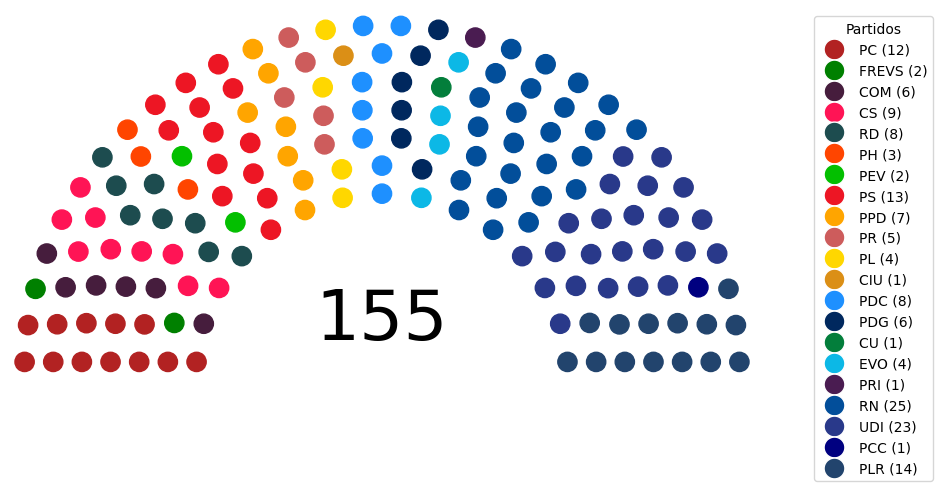

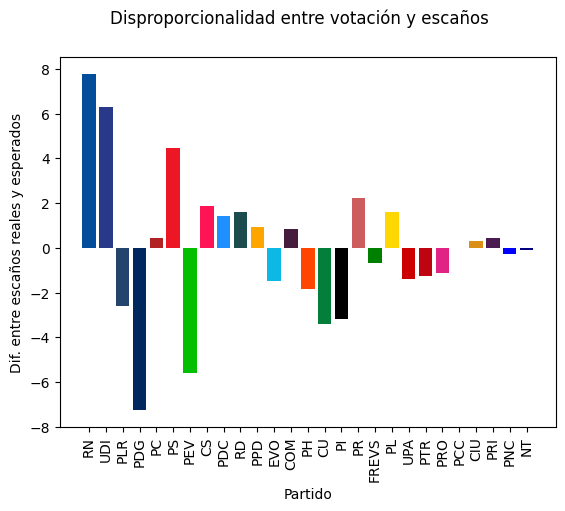

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.62%

Candidatos con menos votos que fueron electos:
                            Pacto Partido  Distrito  Votos (%)
Candidato                                                     
HERNAN PALMA PEREZ             DA      PH        12   0.239757
MONICA TAMARA ARCE CASTRO      DA      PH        12   0.250215
ANDRES GIORDANO SALAZAR        AD      RD         9   0.856237
MARTA AMERICA GONZALEZ OLEA   NPS     PPD        15   0.989451
ANA MARIA BRAVO CASTRO        NPS      PS        24   1.288526

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      RN         2   9.994307
ALEJANDRA VALDEBENITO TORRES         ChP+     UDI        27   9.910182
LEONARDO DANTE SOLARI ALCOTA          FSC     PLR         2   9.903423
JOHN LEANDRO SANCH

In [28]:
results_dhondt = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
app_dhondt = Apportionment(
    results=results_dhondt,
    colors=colors,
    party_order=party_order
)

app_dhondt.summary()

### D'Hondt con umbral nacional

Una de las reformas más mencionadas para el sistema político chileno involucra
la creación de un [umbral
electoral](https://www.t13.cl/noticia/politica/udi-presenta-proyecto-para-establecer-5-votos-para-partidos-politicos-16-1-2024)
a nivel nacional, mediante el cual partido que obtengan una votación nacional
menor al umbral no podrán competir por ningún escaño. Sistemas similares se
utilizan en la [Cámara de Diputados de
Brasil](https://en.wikipedia.org/wiki/Chamber_of_Deputies_(Brazil)), el
[Congreso de
Perú](https://en.wikipedia.org/wiki/Congress_of_the_Republic_of_Peru) y el
[Consejo Nacional de
Austria](https://en.wikipedia.org/wiki/National_Council_(Austria)), aunque cabe
mencionar que ninguno permite la creación de pactos entre partidos (como sí
ocurre en Chile).

El umbral más comúnmente propuesto es del 5%, pero en vista del *dataset* con
el cual se trabaja se utilizará un umbral del 4% para permitir que más partidos
accedan a escaños. En la realidad, se esperaría que de promulgarse esta
reforma, los partidos más pequeños se fusionaran para lograr el 5% (como ya
hizo el [Frente
Amplio](https://elpais.com/chile/2024-07-15/el-frente-amplio-la-formacion-de-boric-elige-su-primera-directiva-tras-la-union-de-sus-partidos.html)).

Características del sistema D'Hondt con umbral nacional:
- Obtiene una baja proporcionalidad nacional a nivel de partidos, con índices
  de disproporcionalidad de 12.83% (Gallagher) y 36.00% (Loosemore-Hanby). Esto
  es de esperar, pues un 28% de los votantes escogieron a partidos con menos
  del 4% de los votos, lo cual implica que no recibieron representación alguna.
  Afortunadamente la proporcionalidad a nivel de pactos es muy parecida al
  sistema estándar, pues al menos los votos "perdidos" de un partido siguen
  valiendo para elegir a candidatos de su pacto, y no son eliminados
  completamente.
- Se mantiene inclinación hacia los pactos más grandes; y ahora se agrega una
  inclinación hacia los partidos que están en pacto con muchos partidos
  pequeños, ya que "absorben" sus votos descartados. Esto es particularmente
  claro en el caso del PS, que tiene 14 diputados más de los que debería por
  proporcionalidad, gracias a que casi todos sus partidos de coalición (PPD,
  PL, PR, CIU) quedaron por debajo del 4% (solo se "salvó" el PDC).
- La proporcionalidad a nivel de distrito es similar a D'Hondt estándar, pero
  con una peor representación a nivel de partido. Un 46.99% de los votantes no
  tienen a nadie de su partido representándolos a nivel de distrito, 7% más que
  en el caso de D'Hondt estándar.
- El nivel de arrastre es incluso peor que D'Hondt estándar, pues ahora se
  pueden escoger candidatos de partidos que no tuvieron votos en el distrito,
  solamente porque son el único partido del pacto con representación a nivel
  nacional. Los 5 diputados menos votados obtuvieron bajo un 1.1% de los votos
  de su distrito, y el diputado mediano obtuvo un 5.34% de los votos de su
  distrito.
- Por otra parte, hay candidaturas que obtuvieron figuras cercanas al 20% y aún
  así no resultaron electas, debido a que su partido a nivel nacional no obtuvo
  el porcentaje necesario. Este dato, contrastado con el alto arrastre, muy
  probablemente no sean bienvenidos por la ciudadanía que espera que los
  candidatos por los cuales ellos votan salgan electos.
- Hay un menor grado de fragmentación partidaria, con solo 10 partidos
  representados en la Cámara, y 7.93 partidos efectivos. La baja diferencia
  entre partidos reales y efectivos indica que la mayoría de partidos tienen
  una presencia notoria en el Congreso (solo el PEV y el PDG tienen menos de 10
  diputados).

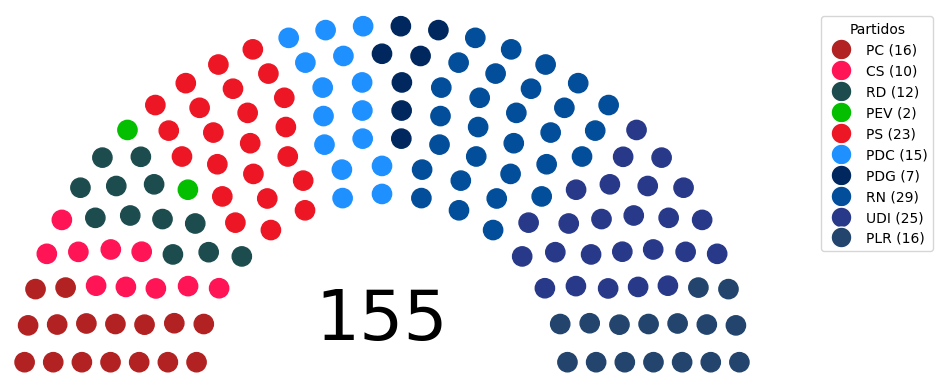

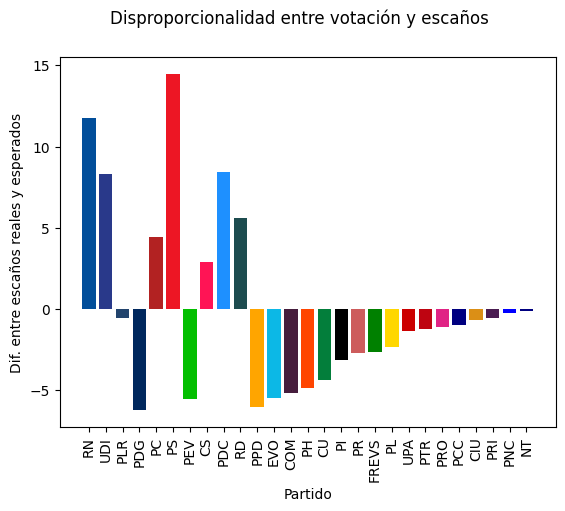

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 5.34%

Candidatos con menos votos que fueron electos:
                                      Pacto Partido  Distrito  Votos (%)
Candidato                                                               
GABRIELA DEL CARMEN MANCILLA MATELUNA   NPS     PDC         4   0.623195
PAULA NIEVAS SILVA                      NPS      PS         3   0.812071
ANDRES GIORDANO SALAZAR                  AD      RD         9   0.856237
CLAUDIA DEL PILAR FAUNDEZ FUENTES      ChP+      RN        12   0.904702
LUCIANO VALLE ACEVEDO                   NPS      PS         6   1.103760

Candidatos con más votos que no fueron electos:
                          Pacto Partido  Distrito  Votos (%)
Candidato                                                   
RAUL SOTO MARDONES          NPS     PPD        15  27.868778
VLADO MIROSEVIC VERDUGO     NPS      PL         1  20.905373
PAMELA JILES MORENO          DA      PH        12  19.79095

In [15]:
results_dhondt_threshold = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.04
)
app_dhondt_threshold = Apportionment(
    results=results_dhondt_threshold,
    colors=colors,
    party_order=party_order
)

app_dhondt_threshold.summary()

### D'Hondt sin pactos

Otra idea que se ha propuesto para el sistema político chileno (aunque sin
particular apoyo parlamentario) consiste en la [eliminación de los pactos entre
partidos](https://www.ciperchile.cl/2024/11/07/reforma-al-sistema-politico-vamos-al-fondo-del-problema/)
para las elecciones. Como se mencionó en [la sección
anterior](#dhondt-con-umbral-nacional), este sistema (con umbrales nacionales)
se utiliza en países como Brasil, Perú y Austria. También se usa con umbrales a
nivel de distrito en la [Cámara de Representantes de
Colombia](https://en.wikipedia.org/wiki/Chamber_of_Representatives_of_Colombia).

**Observación**: en la simulación realizada, se usaron los datos sin pactos,
pero esta información se volvió a agregar tras la simulación para poder
analizar métricas sobre los "pactos" que se formarían *de facto* en el
Congreso. Esto se hará para todas las simulaciones que no utilicen pactos.

Características del sistema D'Hondt sin pactos:
- Obtiene proporcionalidad similar a D'Hondt estándar a nivel de partidos, con
  índices de disproporcionalidad de 7.51% (Gallagher) y 18.50%
  (Loosemore-Hanby).
- Hay una muy clara inclinación hacia los partidos más grandes, con cada uno de
  los 4 partidos más votados (UDI, RN, PLR, PDG) obteniendo 5 escaños más de
  los que deberían por propocionalidad. Esto es particularmente problemático
  para los partidos de izquierda, pues tienden a ser varios partidos más
  pequeños (versus los pocos partidos grandes de la derecha); de implementarse
  este sistema, probablemente veríamos la fusión de partidos pequeños.
- La proporcionalidad a nivel de distrito es similar a D'Hondt estándar, tanto
  para partidos como para pactos. Este es un resultado sorprendente, pues uno
  esperaría que un voto con más información (partido + pacto) entregaría
  resultados más proporcionales respecto a un voto con menos información (solo
  partido, sin saber nada de pactos).
- El nivel de arrastre es similar a D'Hondt estándar, y mejor que D'Hondt con
  umbral nacional. El candidato mediano fue electo con un 6.55% de los votos de
  su distrito.
- El grado de fragmentación parlamentaria es un poco menor que D'Hondt
  estándar, y mayor que D'Hondt con umbral nacional. Hay 19 partidos en el
  parlamento, y 9.64 partidos efectivos.
- Es interesante notar que utilizar D'Hondt con listas abiertas y sin pactos
  inflaría el tamaño de las papeletas, ya que cada partido intentaría competir
  con la mayor cantidad de candidatos posibles (aunque sea infactible que todos
  salgan electos). Una solución para esto sería utilizar listas cerradas (donde
  las personas solo votan por el partido), pero esto podría hacer mella en una
  sociedad chilena que [no aprueba de los partidos
  políticos](https://www.latercera.com/nacional/noticia/cadem-mas-del-90-se-declara-insatisfecho-con-el-funcionamiento-del-poder-judicial-y-del-sistema-politico-chileno/OX4AAAQ7KRHLVKRIPPEQVVKVW4/).

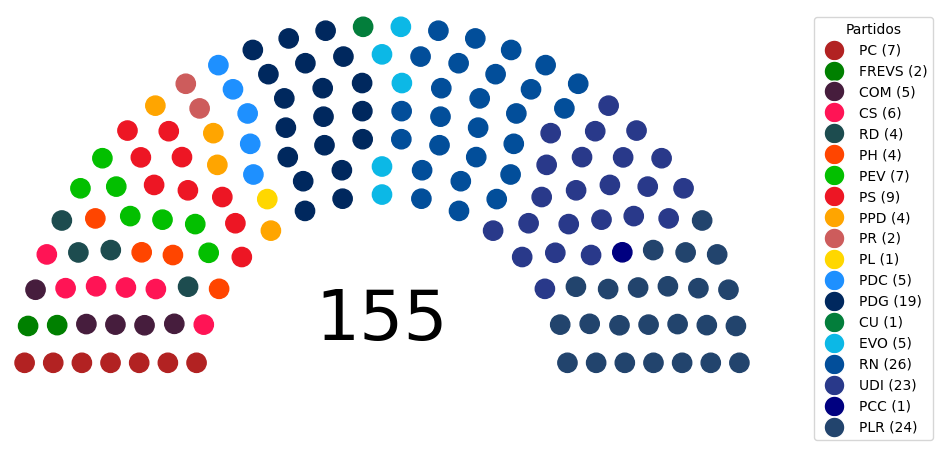

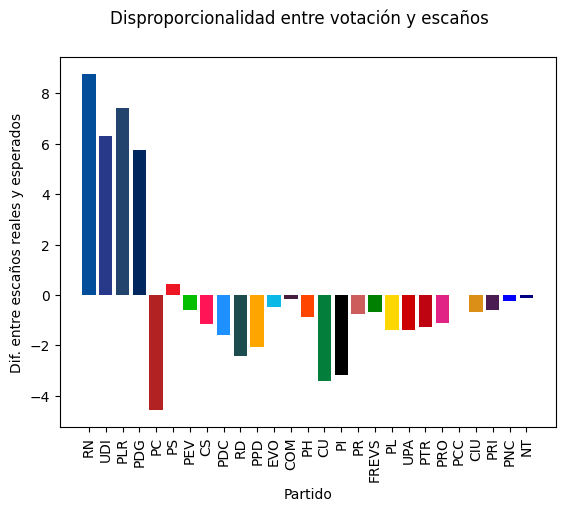

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.55%

Candidatos con menos votos que fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
HERNAN PALMA PEREZ                  DA      PH        12   0.239757
MONICA TAMARA ARCE CASTRO           DA      PH        12   0.250215
MARTA AMERICA GONZALEZ OLEA        NPS     PPD        15   0.989451
ANA MARIA BRAVO CASTRO             NPS      PS        24   1.288526
MARIA SOLEDAD CASTILLO HENRIQUEZ  ChP+      RN        22   1.440352

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      RN         2   9.994307
ALEJANDRA VALDEBENITO TORRES         ChP+     UDI        27   9.910182
MATIAS FELIPE RAMIREZ PASCAL           AD      PC     

In [54]:
results_dhondt_no_pact = appoint_divisor_district(
    df_no_pact,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
results_dhondt_no_pact.loc[:, "pact"] = df["pact"]

app_dhondt_no_pact = Apportionment(
    results=results_dhondt_no_pact,
    colors=colors,
    party_order=party_order
)

app_dhondt_no_pact.summary()

## Sistemas proporcionales nacionales

Los sistemas proporcionales nacionales son muy similares a los sitemas por
distrito, solo que suman todos los votos en un único "distrito nacional". Para
efectos de esta simulación, se realizará la elección de los diputados de cada
partido en base a la cantidad de votos que obtuvieron, y **no se utilizarán
pactos electorales**.

Características de los sistemas proporcionales nacionales:

* Logran una mayor representatividad a nivel nacional que los sistemas
  proporcionales por distrito.
* Como no existe el concepto de distrito, no hay ninguna certeza de que hayan
  representantes de todas las zonas del país en el parlamento. En nuestra
  simulación, esto se verá reflejado en que los distritos más pequeños (como
  Aysén o Magallanes) no tendrán ningún candidato que haya alcanzado los votos
  suficientes como para ser electo, quedándose así sin representación.

### D'Hondt nacional con umbral bajo

La mayoría de países que implementan D'Hondt nacional tienen umbrales
electorales muy pequeños o nulos. Para la [Cámara de Representantes de los
Países
Bajos](https://en.wikipedia.org/wiki/House_of_Representatives_(Netherlands)),
el umbral es equivalente al porcentaje que representa un escaño en el
parlamento (1/150, pues son 150 escaños). En el caso del [Senado de
Uruguay](https://en.wikipedia.org/wiki/Senate_of_Uruguay), no existen umbrales
electorales, aunque debido a la baja cantidad de escaños existe un **umbral
natural** relativamente alto.

Para esta simulación, se decidió usar un umbral electoral como el de los Países
Bajos, aunque en nuestro caso sería 1/155 pues son 155 escaños en la Cámara.
Las diferencias son mínimas si no se usa un umbral, ya que Ciudadanos y el PRI
serían los únicos partidos nuevos que ingresarían al Congreso.

Características de D'Hondt nacional con umbral bajo:
- Obtiene excelentes niveles de proporcionalidad a nivel nacional, con índices
  de disproporcionalidad de 0.85% (Gallagher) y 2.74% (Loosemore-Hanby).
- Hay una leve inclinación hacia partidos más grandes, pero todos están dentro
  de 1.5 escaños de su proporción esperada.
- Como los votos se contaron en una lista nacional, hay algunos distritos que
  no tienen representación alguna. Esto hace que aunque solo un 37.66% de
  personas no tienen a nadie de su partido representándolos en su distrito
  (similar a los experimentos anteriores), hay tres distritos donde un 100% de
  las personas sufren ese problema (pues el distrito no escogió a ningún
  diputado). Aunque esto sea una simulación, sí refleja el problema principal
  de las listas nacionales: la falta de representación asegurada para las zonas
  menos pobladas del país.
- Aunque el concepto de "arrastre" no aplica en este caso, sí es cierto que el
  diputado mediano obutvo solo el 5.68% de los votos de su distrito, y los 5
  diputados menos votados están bajo el 1.7%.
- El grado de fragmentación parlamentaria es altísimo, con 23 partidos en el
  Congreso, y 13.78 partidos efectivos. Este nivel de fragmentación es una
  característica conocida del sistema político neerlandés, hasta el punto que
  ["Dutchification"](https://www.euractiv.com/section/politics/opinion/the-brief-dutchification-is-pushing-europes-governments-to-the-brink/)
  se ha utilizado como sinónimo de fragmentación política.
- Con un único distrito a nivel nacional, sin pactos y con 155 escaños para
  llenar, las papeletas pueden llegar a ser [extraordinariamente
  grandes](https://www.washingtonpost.com/news/worldviews/wp/2017/03/15/with-28-parties-running-dutch-voters-have-to-use-these-literally-enormous-ballots/),
  aunque en los Países Bajos se están probando [métodos
  alternativos](https://nltimes.nl/2024/03/11/five-dutch-municipalities-experiment-small-ballot-european-elections)
  para hacerlas más manejables.

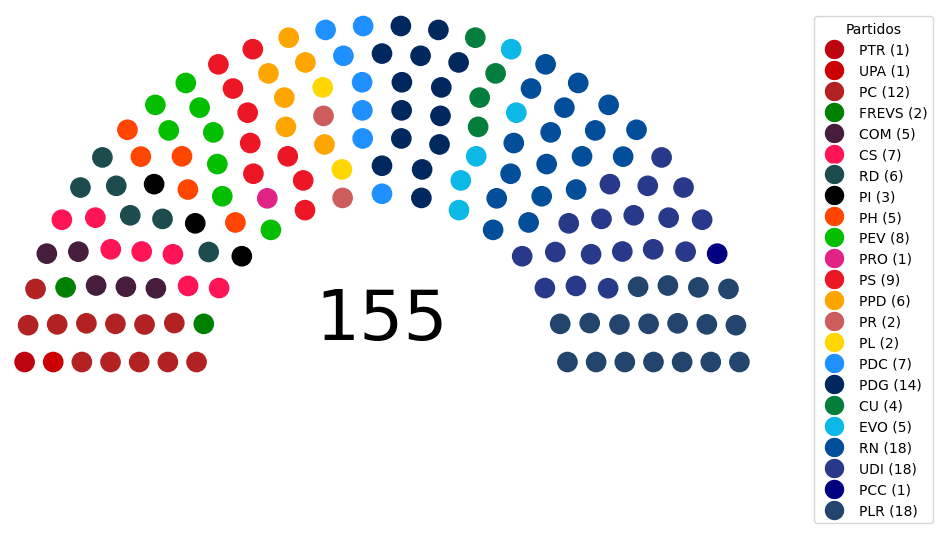

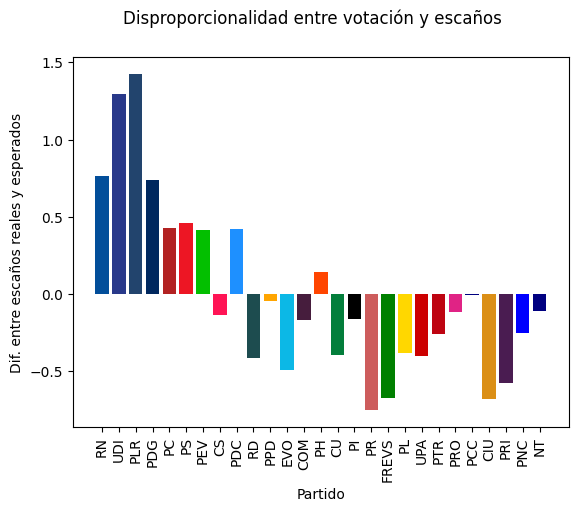

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 5.68%

Candidatos con menos votos que fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
CAMILA PAZ CACERES FUENTES             DA      PH         8   1.126695
EWALD ENRIQUE MEYER MONSALVE          PTR     PTR         6   1.154417
JESSICA DEL CARMEN CAYUPI LLANCALEO    DA      PI         9   1.511747
RUBEN DARIO OYARZO FIGUEROA           PDG     PDG         8   1.597128
MARCOS RAFAEL PAZ SILVA               UPA     UPA        21   1.674171

Candidatos con más votos que no fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
MIGUEL ANGEL CALISTO AGUILA        NPS     PDC        27  26.747603
CHRISTIAN MATHESON VILLAN         ChP+     EVO        28  18.670804
RENE ALINCO BUSTOS                 NPS     PP

In [17]:
results_dhondt_nat = appoint_divisor_national(
    df_no_pact,
    total_seats=155,
    assign_type="dhondt",
    party_threshold=1/155,
    selection_criteria=("votes", False)
)
results_dhondt_nat.loc[:, "pact"] = df["pact"]

app_dhondt_nat = Apportionment(
    results=results_dhondt_nat,
    colors=colors,
    party_order=party_order
)

app_dhondt_nat.summary()

### D'Hondt nacional con umbral alto

Aunque D'Hondt nacional no se usa con umbrales altos en ningún país (a conocimiento del autor), es la primera idea que a uno se le ocurriría para resolver el problema de la fragmentación que ocurre en lugares como los Países Bajos. Se aplicará el mismo umbral de 4% usado para [D'Hondt por distrito con umbral nacional](#dhondt-con-umbral-nacional).

Características de D'Hondt nacional con umbral alto:
- Obtiene excelentes niveles de proporcionalidad aceptables, intermedios entre
  D'Hondt por distrito con y sin umbral. Se obtienen índices de
  disproporcionalidad de 9.02% (Gallagher) y 27.98% (Loosemore-Hanby).
- Debido al uso del método D'Hondt y la supresión de partidos con pocos votos,
  existe una inclinación hacia partidos más grandes; sin embargo, no es tan
  grande como en D'Hondt por distrito con umbral nacional.
- Al igual que D'Hondt nacional con umbral bajo, hay una diferencia en
  representatividad entre distritos. Sin embargo, como hay menos candidatos
  disponibles para elegir (pues se eliminaron muchos partidos), al menos en
  esta simulación todos los distritos obtuvieron algo de representación. Sin
  embargo, se tiene que un 48.15% (casi la mitad del electorado) no tiene a
  nadie de su partido representándolo en su distrito, y que un pues un 28% de
  los votantes escogieron a partidos con menos del 4% de los votos, lo cual
  implica que no recibieron representación alguna a nivel nacional.
- El concepto de "arrastre" nuevamente no aplica, y esta vez el diputado
  mediano obtuvo el 6.39% de los votos (mayor que con un umbral bajo). Sin
  embargo, existen diputados con más del 20% de los votos en su distrito que no
  fueron electos, debido a que el partido no alcanzó el umbral del 4%.
- Hay un bajo grado de fragmentación, con 10 partidos en el Congreso, y 8.71
  partidos efectivos.
- Al igual que para D'Hondt nacional con umbral bajo, se tiene el problema de
  las papeletas posiblemente enormes.

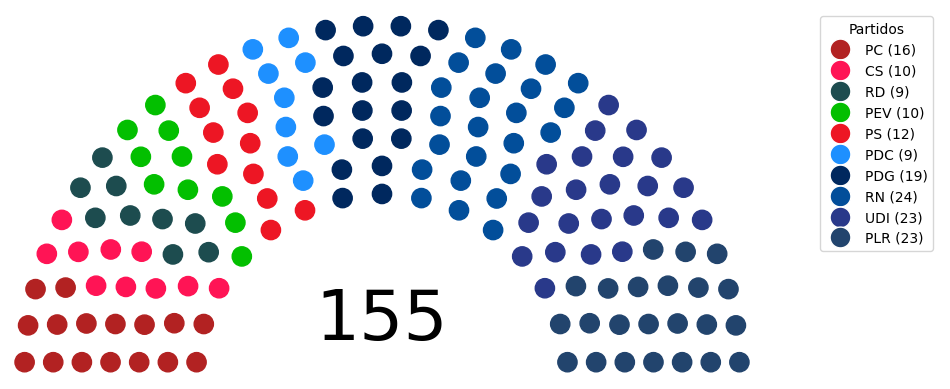

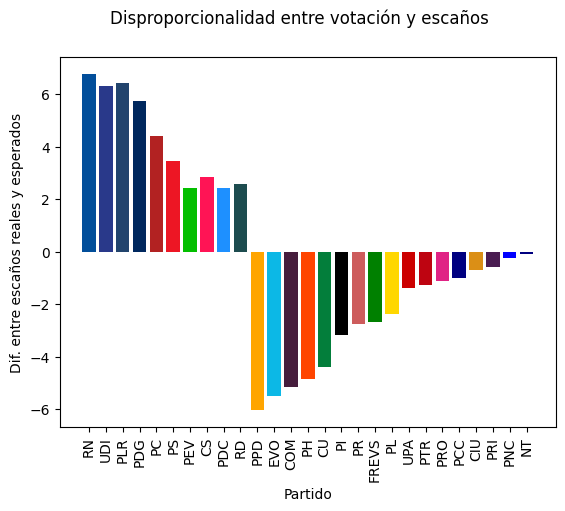

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 5.02%

Candidatos con menos votos que fueron electos:
                               Pacto Partido  Distrito  Votos (%)
Candidato                                                        
VICTOR HUGO ANTIL CAYUQUEO       PDG     PDG         8   1.331591
RUBEN DARIO OYARZO FIGUEROA      PDG     PDG         8   1.597128
MANUEL ANDRES AHUMADA LETELIER    AD      PC        10   1.679236
ALEJANDRA PAMELA JARA QUIROZ     PDG     PDG        12   1.707634
LUZ JANETH ESPINAL MORENO        FSC     PLR         8   1.723005

Candidatos con más votos que no fueron electos:
                          Pacto Partido  Distrito  Votos (%)
Candidato                                                   
RAUL SOTO MARDONES          NPS     PPD        15  27.868778
VLADO MIROSEVIC VERDUGO     NPS      PL         1  20.905373
PAMELA JILES MORENO          DA      PH        12  19.790952
CHRISTIAN MATHESON VILLAN  ChP+     EVO        

In [18]:
results_dhondt_nat_threshold = appoint_divisor_national(
    df_no_pact,
    total_seats=155,
    assign_type="dhondt",
    party_threshold=0.04,
    selection_criteria=("votes", False)
)
results_dhondt_nat_threshold.loc[:, "pact"] = df["pact"]

app_dhondt_nat_threshold = Apportionment(
    results=results_dhondt_nat_threshold,
    colors=colors,
    party_order=party_order
)

app_dhondt_nat_threshold.summary()

## Sistemas bipartidistas

Estos sistemas, contrario a los anteriores, no velan por un alto nivel de proporcionalidad (ni distrital ni nacional), cambiándolo por menor fragmentación (lo cual, en teoría, implica mayor gobernabilidad).

Características de los sistemas bipartidistas:
* Tienen un bajo nivel de proporcionalidad, tanto a nivel país como distrito.
* Son muy susceptibles al [voto
  estratégico](https://en.wikipedia.org/wiki/Strategic_voting).
* Tienden a [degenerar a un sistema
  bipartidista](https://en.wikipedia.org/wiki/Duverger%27s_law) dado el
  suficiente tiempo (de ahí proviene el nombre de la categoría).
* Disminuyen la fragmentación política, pues solo permiten que los partidos más
  grandes accedan a escaños en el Congreso.
* En general son muy sencillos de entender.

### Binomial

El sistema binominal es un sistema D'Hondt por distrito (y usando pactos), con
la peculiaridad de que todos los distritos escogen exactamente 2 escaños. Su
uso más conocido fue en las elecciones de la Cámara de Diputados y el Senado
[en Chile](https://en.wikipedia.org/wiki/Binomial_voting_system), entre 1989 y
2013.

Características del sistema binomial:
- Obtiene niveles de proporcionalidad aceptables, no mucho peores que D'Hondt
  estándar, con índices de disproporcionalidad de 11.68% (Gallagher) y 27.79%
  (Loosemore-Hanby).
- Hay una clara inclinación hacia los tres pactos que tienen más votos, y que
  han establecido dominancia en sectores del país (ChP+, NPS y AD). Partidos
  con votaciones importantes pero más repartidas a lo largo del país (como el
  PLR y especialmente el PDG) no logran ser una de las dos primeras mayorías en
  prácticamente ningún distrito, con lo cual obtienen muy pocos escaños.
- Esto último actúa como elemento disuasorio para quieres quieren votar por un
  pacto más pequeño: como su voto "no importa" en esos casos, prefieren votar
  por los pactos establecidos que más se parezcan. Esto genera aún menor
  votación para los pactos pequeños, formando un círculo vicioso que termina
  con los pactos disolviéndose o siendo absorbidos por uno más grande.
- La proporcionalidad a nivel de distrito es baja: un 47.85% de los votantes
  (casi la mitad) no tienen a nadie de su pacto representándolos en su
  distrito.
- Hay bajos niveles de "arrastre", pues solo se escogen dos candidatos por
  distrito; solo hay arrastre cuando un pacto recibe más de el doble de votos que
  cualquier otro. El diputado mediano obtuvo el 13.13% de los votos de su
  distrito, lo cual es bastante alto.
- Aunque el diputado mediano recibe más votos que en otros sistemas, también
  ocurre que hay diputados con muchos votos que no son electos: en el caso más
  extremo, un diputado obtuvo más del 20% de los votos en su distrito (siendo
  la primera mayoría), pero no fue electo porque otros dos pactos lograron
  sumar unos pocos votos más.
- El grado de fragmentación parlamentaria parece alto en primera instancia, con
  18 partidos en el Congreso, y 9.67 partidos efectivos. Sin embargo, solo hay
  3.31 pactos efectivos, lo cual indica que aunque hayan varios partidos
  pequeños con algo de representación, en verdad solo hay tres fuerzas
  políticas importantes en el Congreso (ChP+, NPS y AD).
- Como cada pacto presenta a lo más dos candidatos, se tiene que las papeletas
  son manejables, los votos son rápidos de contar, y el sistema es
  relativamente sencillo de entender (al menos en comparación a un D'Hondt con
  más escaños por distrito).

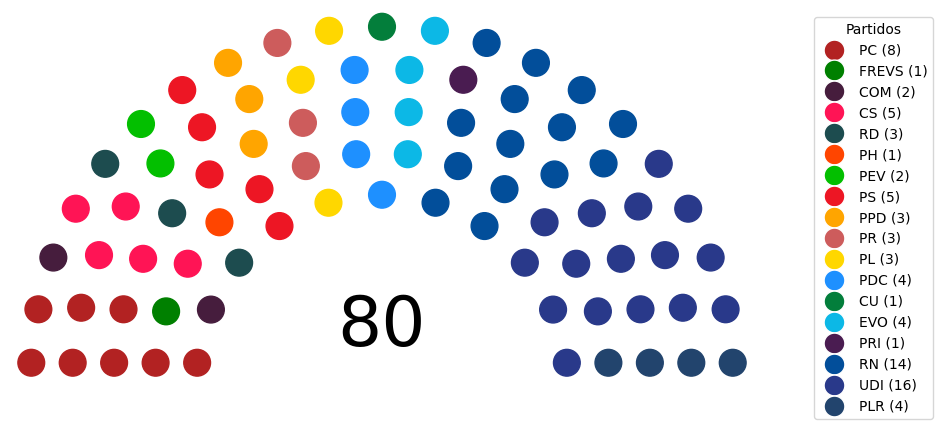

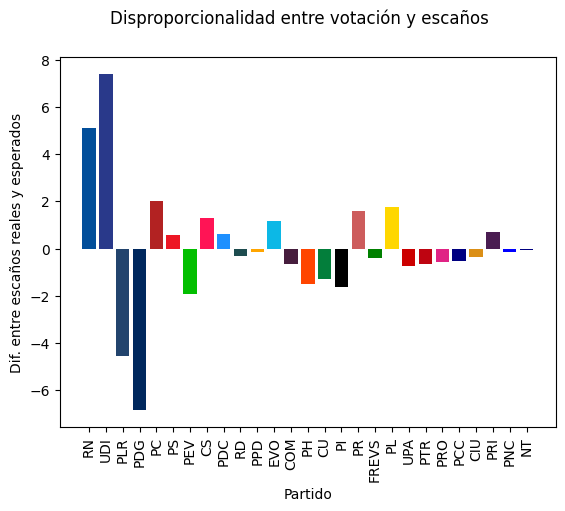

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 13.13%

Candidatos con menos votos que fueron electos:
                                             Pacto Partido Distrito  Votos (%)
Candidato                                                                     
HECTOR RODRIGUEZ MENDOZA                      ChP+     EVO      10a   1.840551
ALONDRA CATERINA LIBERTAD ARELLANO HERNANDEZ    AD      CS      14a   3.328654
NATHALIE CASTILLO ROJAS                         AD      PC       5a   5.195485
NATALIA ROMERO TALGUIA                        ChP+     UDI      15a   5.208590
FERNANDO BORQUEZ MONTECINOS                   ChP+     UDI      26a   5.443697

Candidatos con más votos que no fueron electos:
                                     Pacto Partido Distrito  Votos (%)
Candidato                                                             
GONZALO ARMANDO DE LA CARRERA CORREA   FSC     PLR      11a  22.182792
HARRY JURGENSEN RUNDSHAGEN             FSC     

In [19]:
results_bin = appoint_divisor_district(
    df_bin,
    district_seats=district_seats_bin,
    assign_type="dhondt",
    party_threshold=0.0
)

app_bin = Apportionment(
    results=results_bin,
    colors=colors,
    party_order=party_order
)

app_bin.summary()

### Uninominal (first-past-the-post)

El sistema uninominal (conocido coloquialmente en inglés como
*first-past-the-post*) es un sistema de mayoría simple, donde solo hay un
escaño por distrito, y el candidato que obtiene más votos se lo queda. Este
modelo es ampliamente usado, incluyendo en la [Cámara de Representantes de los
Estados
Unidos](https://en.wikipedia.org/wiki/United_States_House_of_Representatives),
la [Cámara de los Comunes del Reino
Unido](https://en.wikipedia.org/wiki/House_of_Commons_of_the_United_Kingdom) y
la [Cámara de los Comunes de
Canadá](https://en.wikipedia.org/wiki/House_of_Commons_of_Canada). También se
usa para escoger [alcaldes en
Chile](https://en.wikipedia.org/wiki/Elections_in_Chile#Municipal_elections).

Para efectos de la simulación, como en cada distrito hay varios candidatos por
pacto (contrario a las elecciones de alcalde), una mayoría simple entre todos
los candidatos daría resultados distintos a la realidad. Por ejemplo, dos
candidatos del partido A que obtienen el 20% cada uno serían vencidos por un
candidato del partido B que obtuvo un 25%, aunque en la realidad solo se
lanzaría un candidato del partido A (que obtendría el 40% de los votos y
ganaría). Para mitigar este problema, en vez de escoger al candidato más
votado, se escogerá al **pacto** más votado, luego al partido más votado dentro
de ese pacto, y finalmente al candidato más votado dentro de ese partido
(equivalente a D'Hondt con un solo escaño por distrito).

Características del sistema uninominal:
- Obtiene niveles de proporcionalidad aceptables, muy similares al binomial,
  con índices de disproporcionalidad de 11.60% (Gallagher) y 25.64%
  (Loosemore-Hanby).
- Al igual que el binomial, tiene una clara inclinación hacia los tres pactos
  más votados (ChP+, NPS y AD). Partidos como el PLR y el PDG siguen teniendo
  una representación muy por debajo de la que su porcentaje de votación
  indicaría que merecen.
- También se observa el "círculo vicioso" del sistema binomial, donde los
  pactos más pequeños pierden cada vez más apoyo (ya que la gente no quiere
  "perder" su voto), y terminan disolviéndose o siendo absorbidos.
- La proporcionalidad a nivel de distrito es bajísima: un sorprendente 60.57%
  de los votantes no tienen a nadie de su pacto representándolos en su
  distrito. Esto significa que una amplia mayoría de los votantes están en
  desacuerdo con la persona que lo "representa" en el Congreso.
- No existe el arrastre, pues solo se escoge un candidato por distrito. El
  diputado medio obtuvo el 25.51% de los votos de su distrito, el porcentaje
  más alto de todos los sistemas que se han estudiado.
- Al igual que en el sistema binomial, ocurre que hay diputados con muchos
  votos que no son electos. Como solo hay un escaño por distrito, el efecto es
  más exagerado aún, con 5 candidatos que obtuvieron más del 25% de los votos
  de su distrito pero no fueron electos.
- Similar al binomial, el grado de fragmentación parlamentaria puede parecer
  alto, con 17 partidos en el Congreso, y 8.79 partidos efectivos. Sin embargo,
  con 3.57 pactos efectivos, se puede concluir que solo hay tres fuerzas
  verdaderamente influyentes en el Congreso.
- Como cada pacto presenta solo un candidato, es el sistema más sencillo de
  entender y procesar, algo que es importante para legitimar el proceso a ojos
  de la sociedad.

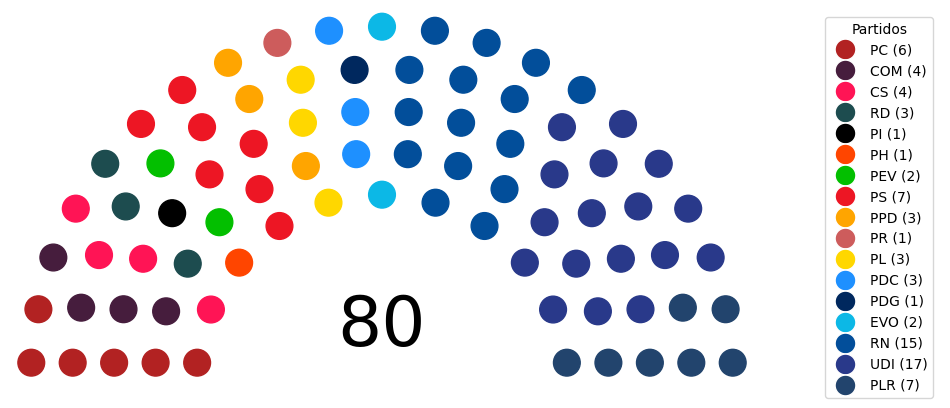

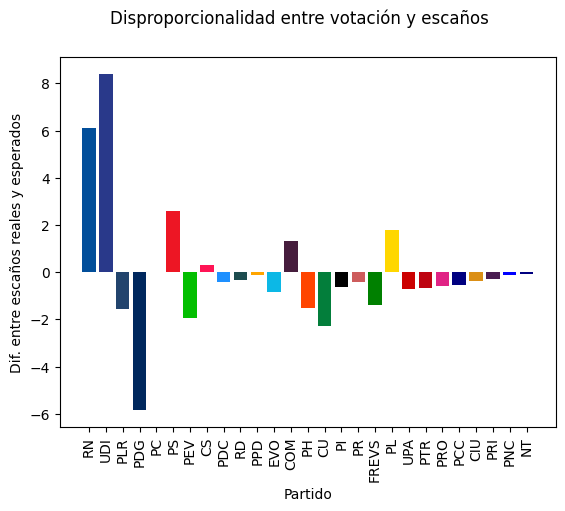

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 25.51%

Candidatos con menos votos que fueron electos:
                                    Pacto Partido Distrito  Votos (%)
Candidato                                                            
MARCOS EMILFORK KONOW                ChP+     UDI      26a   9.675501
MATIAS FELIPE RAMIREZ PASCAL           AD      PC       2a   9.884447
MERCEDES BULNES NUÑEZ                  AD      RD      17b  10.447946
ALEJANDRO JAVIER BERNALES MALDONADO   NPS      PL      26b  11.851995
PAULA LABRA BESSERER                 ChP+      RN      18a  11.902546

Candidatos con más votos que no fueron electos:
                           Pacto Partido Distrito  Votos (%)
Candidato                                                   
ANDRES LONGTON HERRERA      ChP+      RN       6a  30.437641
MIGUEL CONCHA MANSO           AD      RD      11b  29.759487
HARRY JURGENSEN RUNDSHAGEN   FSC     PLR      25a  28.388182
KARLA PINTO TIMMER

In [20]:
results_mono = appoint_divisor_district(
    df_mono,
    district_seats=district_seats_mono,
    assign_type="dhondt",
    party_threshold=0.0
)

app_mono = Apportionment(
    results=results_mono,
    colors=colors,
    party_order=party_order
)

app_mono.summary()

## Sistema biproporcional

El sistema biproporcional se creó como una alternativa para asegurar
representación en dos niveles: la cantidad de escaños por partido es
proporcional a su votación nacional, y la cantidad de escaños por distrito es
proporcional a su población. Esto se logra asignando *divisores* a cada partido
y distrito, donde la cantidad de escaños de un partido en un distrito es
equivalente a los votos que obtuvo dividido en **ambos** divisores.
Inicialmente los divisores son 1 para cada partido, y la cantidad de votantes
por escaño para cada distrito; luego, los divisores son ajustados levemente
para asegurar una asignación apropiada.

Este sistema es utilizado para elecciones locales en algunos cantones de Suiza,
siendo usado por primera vez en el [Consejo Cantonal de
Zúrich](https://en.wikipedia.org/wiki/Cantonal_Council_of_Zurich) en 2006.

Se decidió simular el sistema biproporcional asignando escaños a los partidos
con el método de Sainte-Laguë (usado en Suiza), con un umbral electoral
nacional equivalente a un escaño; de esta manera se pueden comparar los
resultados obtenidos con [D'Hondt nacional con umbral
bajo](#dhondt-nacional-con-umbral-bajo).

**Observación:** como, en esta simulación, no todos los partidos tienen tantos
candidatos como escaños disponibles en cada distrito, es posible que un partido
sea asignado más escaños en un distrito que el número de candidatos que
presentó. Por simplicidad, se decidió dejar ese escaño vacío para efectos de la
simulación; debido a esto solo hay 154 escaños asignados (el PC obtuvo 2
escaños en el distrito 14, pero solo tenía a una candidata).

Características del sistema biproporcional:
- Es un sistema complejo, donde no existe una manera fácil de entender la razón
  por la cual un candidato fue electo por sobre otro. La matemática tiene
  sentido y es fácil verificar una asignación correcta si se tiene acceso a los
  divisores usados, pero tampoco es sencillo justificar la elección de
  divisores a personas que no estén interesadas en la matemática ni la
  politica.
- Obtiene excelentes niveles de proporcionalidad a nivel nacional, con índices
  de disproporcionalidad de 0.89% (Gallagher) y 2.80% (Loosemore-Hanby).
- Al usarse Sainte-Laguë en vez de D'Hondt, no hay inclinación hacia partidos
  más grandes, y todos están en un rango de 0.6 escaños de lo esperado.
- Contrario a D'Hondt nacional, cada distrito tiene una cantidad fija de
  representantes, los cuales son escogidos para representar de mejor maneras
  las opiniones del distrito (aunque considerando la cantidad de escaños que
  cada partido debe ser asignado a nivel nacional). Se obtiene que un 35.74% de
  los votantes no tienen a nadie de su partido representándolos en su distrito,
  un número similar a los modelos anteriores.
- Un problema del sistema biproporcional es que los partidos que merecen un
  escaño, pero no tienen una votación muy alta en ningún distrito, van a
  obtener un representante para un distrito en el cual solo obtuvieron un 1% (o
  menos) de los votos. Esto ocurre con el único representante de UPA (en el
  distrito 20), y probablemente confunda a los habitantes de ese distrito que
  tienen a un representante "desconocido", solo porque gente de otros distritos
  votó por UPA.
- Al igual que D'Hondt por distrito, se genera un importante nivel de arrastre;
  los 5 diputados menos votados obtuvieron bajo un 1.1% de los votos de su
  distrito, y el diputado mediano obtuvo un 6.53% de los votos de su distrito.
- Al igual que D'Hondt nacional, el grado de fragmentación parlamentaria es
  altísimo, con 23 partidos en el Congreso, y 14.62 partidos efectivos.
- El sistema se puede calibrar cambiando el umbral nacional, o agregando
  umbrales distritales (un partido debe obtener un $X\%$ de votos en al menos
  $Y$ distritos para poder acceder a escaños). Sin embargo, estas restricciones
  harían aún más complejo un sistema que ya es difícil de entender por sí solo.

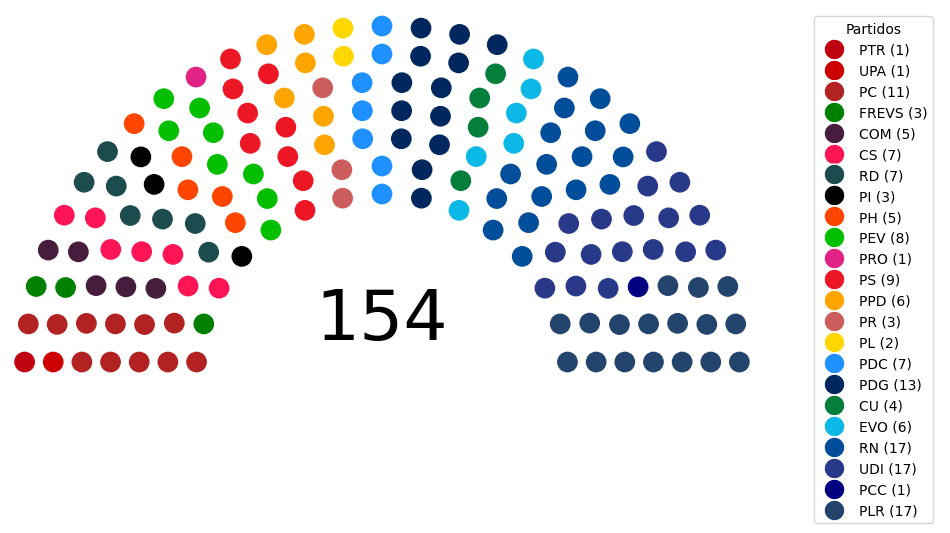

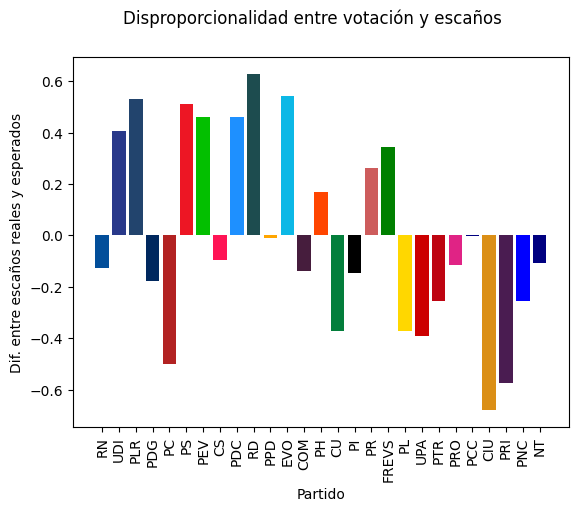

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.53%

Candidatos con menos votos que fueron electos:
                                  Pacto Partido  Distrito  Votos (%)
Candidato                                                           
MONICA TAMARA ARCE CASTRO            DA      PH        12   0.250215
MACARENA CRISTINA ARIAS HERNANDEZ    IU      CU        20   0.800785
GASTON ALFREDO FLORES ORDENES       UPA     UPA        20   0.820696
MARTA AMERICA GONZALEZ OLEA         NPS     PPD        15   0.989451
MARIA LORETO RETAMAL GRIMBERG        IU      CU         5   1.016379

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RENZO TRISOTTI MARTINEZ              ChP+     UDI         2  11.085921
MARCIA RAPHAEL MORA                  ChP+      RN        27  10.717719
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      

In [21]:
results_biprop = appoint_biproportional(
    df_no_pact,
    district_seats=district_seats,
    assign_type="sainte-lague",
    party_threshold=1/155
)
results_biprop["pact"] = df["pact"]

app_biprop = Apportionment(
    results=results_biprop,
    colors=colors,
    party_order=party_order
)

app_biprop.summary()

## Sistemas mixtos

Otra forma de balancear representatividad distrital y nacional son los **sistemas mixtos**. Estos tienen dos fases: la primera asigna escaños a cada distrito (asegurando que todos tengan un mínimo de representación), mientras que la segunda asigna escaños a nivel nacional (compensando las posibles desigualdades generadas en la primera etapa). Se puede ver como una mezcla entre un sistema por distrito (ya sea proporcional o no) y un sistema proporcional nacional.

Características de sistemas mixtos:
- Logran una mayor representatividad a nivel nacional que los sistemas proporcionales por distrito, aunque son peores que los sistemas proporcionales nacionales.
- Inversamente, logran una peor representatividad a nivel distrital que los sistemas proporcionales por distrito, pero aseguran representación para todos los distritos (contrario a los sistemas proporcionales nacionales).
- Son más sencillos de entender que el sistema biproporcional.
- Son susceptibles a votación estratégica y manipulación electoral (especialmente cuando hay partidos que aseguran los suficientes escaños distritales como para no poder acceder a ningún escaño compensatorio).

### Mixed-Member Proportional / Additional-Member System

La representación proporcional mixta (Mixed-member proportional, MMP) es un
sistema mixto donde en la primera fase, cada distrito elige a un solo candidato
(el que obtenga más votos); luego, se asignan escaños compensatorios a nivel
nacional para asegurar proporcionalidad. Si la proporcionalidad absoluta no se
puede obtener debido a que un partido ganó demasiados escaños distritales,
existen varias maneras de abordar el problema:
- Agregar escaños extra (*overhang seats*), que son entregados a los partidos
  que ganaron demasiados escaños distritales; este es el sistema usado en la
  [Cámara de Representantes de Nueva
  Zelanda](https://en.wikipedia.org/wiki/New_Zealand_House_of_Representatives).
  Causa que el tamaño del parlamento sea variable, pero generalmente agrega
  pocos escaños.
- Agregar escaños extra, que son entregados a los partidos que **no ganaron**
  demasiados escaños distritales hasta que se se alcance la proporcionalidad;
  este es el sistema que fue usado hasta las elecciones de 2021 en el
  [Bundestag de Alemania](https://en.wikipedia.org/wiki/Bundestag). Asegura
  proporcionalidad, pero puede inflar muchísimo el tamaño del parlamento (en el
  caso de las últimas elecciones alemanas, pasó [de 598 a
  735](https://en.wikipedia.org/wiki/2021_German_federal_election)).
- Eliminar los escaños distritales en exceso, reemplazándolos por escaños a
  nivel nacional; este es el sistema que será usado a partir de 2025 en el
  Bundestag de Alemania. Mantiene constante el tamaño del parlamento, pero
  causa que algunos distritos pierdan su derecho a un representante.
- Asignar los escaños compensatorios que se puedan, manteniendo todos los
  escaños distritales; este sistema, también conocido como **Additional-member
  system** (AMS), es usado en la [Cámara de Diputados de
  Bolivia](https://en.wikipedia.org/wiki/Chamber_of_Deputies_(Bolivia)) y el
  [Parlamento Escocés](https://en.wikipedia.org/wiki/Scottish_Parliament).
  Mantiene constante el tamaño del parlamento y asegura que todos los distritos
  tengan representación, pero no asegura proporcionalidad.

Para efectos de esta simulación, se decidió utilizar **AMS**, manteniendo un
parlamento de 120 diputados. 80 de los diputados son electos en distritos
usando el [sistema uninominal](#uninominal-first-past-the-post), y 40 son
asignados usando [D'Hondt a nivel nacional](#dhondt-nacional-con-umbral-alto),
con un umbral del 4%. Los escaños niveladores de cada partido fueron asignados
a sus candidatos con más votos (que no hayan sido electos en su distrito); esto
se conoce como [*Zweitmandat*](https://en.wikipedia.org/wiki/Zweitmandat), y
fue usado en el [Landtag de
Baden-Württemberg](https://en.wikipedia.org/wiki/Landtag_of_Baden-W%C3%BCrttemberg)
hasta el año 2022. 

Características de MMP/AMS:
- Obtiene niveles de proporcionalidad aceptables a nivel nacional, con índices
  de disproporcionalidad de 5.46% (Gallagher) y 16.44% (Loosemore-Hanby).
- Hay una leve inclinación hacia los partidos que tienen mucha fuerza en pocos
  distritos (PL o UDI) por sobre quienes tienen poca fuerza en muchos distritos
  (PDG o PEV), pues son capaces de ganar más escaños distritales que los que
  merecerían bajo un régimen de proporcionalidad. Esto también genera una
  posibilidad para manipulación electoral, pues si un partido no se beneficia
  obteniendo votos fuera de los distritos que gana directamente (ya que no
  puede optar a escaños nacionales), entonces le conviene más solo poner
  candidatos en los distritos que va a ganar, y hacer que sus votantes
  entreguen apoyo a otros partidos del sector. Así se inflarían los números de
  los otros partidos del sector, causando que les entreguen más asientos de lo
  esperado.
- Se obtiene una proporcionalidad baja a nivel de distrito; una mayoría del
  electorado ni siquiera tiene a alguien de su pacto representándolo; esto es
  de esperar, pues muchos de los distritos solo tienen a un representante. Sin
  embargo, los votos que no fueron al ganador del distrito no se "pierden",
  pues son utilizados durante la asignación de escaños niveladores. Quizás esos
  escaños son asignados en otros distritos, pero al menos son utilizados
  (contrario a lo que ocurre con los votos perdidos de D'Hondt por distrito).
- Como cada distrito elige a solo un representante, no existe el arrastre; el
  diputado mediano es electo con un 20.59% de los votos de su distrito.

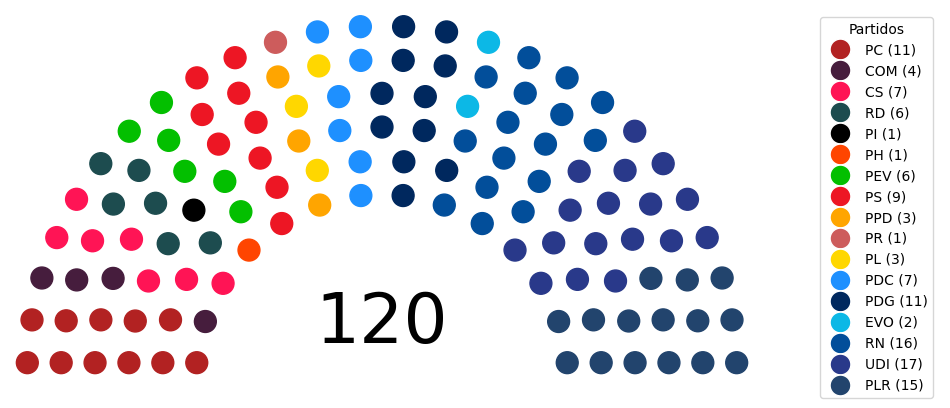

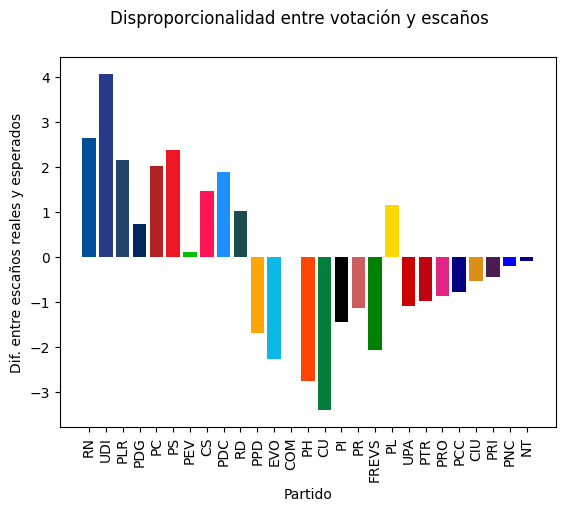

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 20.59%

Candidatos con menos votos que fueron electos:
                                     Pacto Partido Distrito  Votos (%)
Candidato                                                             
NICOLAS FRANCISCO AGUILERA FERNANDEZ   PDG     PDG      17a   7.625326
DENISSE CAROLINA GALLEGOS CASTRO       PDG     PDG       2a   8.064758
JOSE CARLOS MEZA PEREIRA               FSC     PLR       9a   8.754734
NICOLAS PREUSS HERRERA                 NPS     PDC      11e   8.991673
RUBEN DARIO OYARZO FIGUEROA            PDG     PDG       8a   9.357630

Candidatos con más votos que no fueron electos:
                                  Pacto Partido Distrito  Votos (%)
Candidato                                                          
JOAQUIN LAVIN LEON                 ChP+     UDI       8d  25.026111
FRANCISCO PULGAR CASTILLO            IU      CU      17a  24.765668
TOMAS IGNACIO LAGOMARSINO GUZMAN    NPS     

In [55]:
results_ams = appoint_divisor_mixed(
    df_mono,
    fixed_district_seats=district_seats_mono,
    top_up_seats=40,
    district_type="dhondt",
    national_type="dhondt",
    district_party_threshold=0.00,
    national_party_threshold=0.04,
    district_selection_criteria=("votes", False),
    national_selection_criteria=("votes", False)
)

app_ams = Apportionment(
    results=results_ams,
    colors=colors,
    party_order=party_order
)

app_ams.summary()